In [2]:
from PIL import Image
from pytesseract import *
from fnmatch import fnmatch
from queue import Queue
import matplotlib.pyplot as plt
import cv2
import time
import os
from sklearn.cluster import KMeans

## CFS: Connected Component Labeling

In [3]:
# Adaptive Threshold Binarization
def _get_dynamic_binary_image(filedir, img_name):

  filename =   './try/' + img_name.split('.')[0] + '-binary.jpg'
  img_name = filedir + '/' + img_name
  print('.....' + img_name)
  im = cv2.imread(img_name)
  plt.imshow(im)
  im = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)

  th1 = cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 1)
  cv2.imwrite(filename,th1)
  #plt.imshow(th1)
  return th1

# Manual Binarization
def _get_static_binary_image(img, threshold = 140):

  img = Image.open(img)
  img = img.convert('L')
  pixdata = img.load()
  w, h = img.size
  for y in range(h):
    for x in range(w):
      if pixdata[x, y] < threshold:
        pixdata[x, y] = 0
      else:
        pixdata[x, y] = 255

  return img

In [4]:
def cfs(im,x_fd,y_fd):

  xaxis=[]
  yaxis=[]
  visited =set()
  q = Queue()
  q.put((x_fd, y_fd))
  visited.add((x_fd, y_fd))
  offsets=[(1, 0), (0, 1), (-1, 0), (0, -1)]

  while not q.empty():
      x,y=q.get()

      for xoffset,yoffset in offsets:
          x_neighbor,y_neighbor = x+xoffset,y+yoffset

          if (x_neighbor,y_neighbor) in (visited):
              continue  # already visited

          visited.add((x_neighbor, y_neighbor))

          try:
              if im[x_neighbor, y_neighbor] == 0:
                  xaxis.append(x_neighbor)
                  yaxis.append(y_neighbor)
                  q.put((x_neighbor,y_neighbor))

          except IndexError:
              pass
  # print(xaxis)
  if (len(xaxis) == 0 | len(yaxis) == 0):
    xmax = x_fd + 1
    xmin = x_fd
    ymax = y_fd + 1
    ymin = y_fd

  else:
    xmax = max(xaxis)
    xmin = min(xaxis)
    ymax = max(yaxis)
    ymin = min(yaxis)
    #ymin,ymax=sort(yaxis)

  return ymax,ymin,xmax,xmin

# Search block start point
def detectFgPix(im,xmax):

  h,w = im.shape[:2]
  for y_fd in range(xmax+1,w):
      for x_fd in range(h):
          if im[x_fd,y_fd] == 0:
              return x_fd,y_fd

# Cut character position
def CFS(im):

  zoneL=[]
  zoneWB=[]
  zoneHB=[]

  xmax=0
  for i in range(10):

      try:
          x_fd,y_fd = detectFgPix(im,xmax)
          # print(y_fd,x_fd)
          xmax,xmin,ymax,ymin=cfs(im,x_fd,y_fd)
          L = xmax - xmin
          H = ymax - ymin
          zoneL.append(L)
          zoneWB.append([xmin,xmax])
          zoneHB.append([ymin,ymax])

      except TypeError:
          return zoneL,zoneWB,zoneHB

  return zoneL,zoneWB,zoneHB

In [5]:
def cutting_img(im,im_position,img,xoffset = 1,yoffset = 1):
  filename =  './try/' + img.split('.')[0]
  
  # The number of characters recognized
  im_number = len(im_position[1])
  cropped_images = []  # List to store cropped images
  
  # Cut characters
  for i in range(im_number):
    im_start_X = im_position[1][i][0] - xoffset
    im_end_X = im_position[1][i][1] + xoffset
    im_start_Y = im_position[2][i][0] - yoffset
    im_end_Y = im_position[2][i][1] + yoffset
    cropped = im[im_start_Y:im_end_Y, im_start_X:im_end_X]
    cv2.imwrite(filename + '-cutting-' + str(i) + '.png',cropped)

    # Convert BGR to RGB for proper display in matplotlib
    cropped_rgb = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)
    cropped_images.append(cropped_rgb)  # Append to list

  for i, img in enumerate(cropped_images):
      plt.figure(figsize=(2, 2))
      plt.imshow(img)
      plt.axis("off")
      # plt.title(f"Character {i+1}")
      plt.show()


In [6]:
def cutting_img(im,im_position,img,xoffset = 1,yoffset = 1):
  filename =  './out_img/' + img.split('.')[0]
  
  im_number = len(im_position[1])
  cropped_images = []  # List to store cropped images
  
  for i in range(im_number):
    im_start_X = im_position[1][i][0] - xoffset
    im_end_X = im_position[1][i][1] + xoffset
    im_start_Y = im_position[2][i][0] - yoffset
    im_end_Y = im_position[2][i][1] + yoffset
    cropped = im[im_start_Y:im_end_Y, im_start_X:im_end_X]
    cv2.imwrite(filename + '-cutting-' + str(i) + '.png',cropped)

    # Convert BGR to RGB for proper display in matplotlib
    cropped_rgb = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)
    cropped_images.append(cropped_rgb)  # Append to list

  for i, img in enumerate(cropped_images):
      plt.figure(figsize=(2, 2))  
      plt.imshow(img)
      plt.axis("off")
      plt.title(f"Character {i+1}") 
      plt.show()


....../try/wtvaivr-0.png


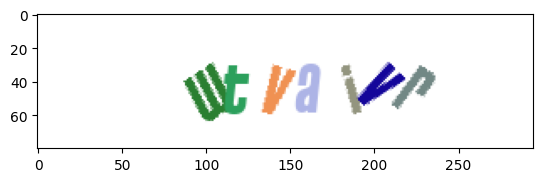

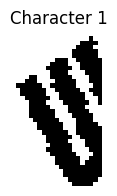

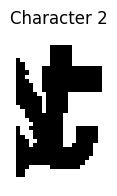

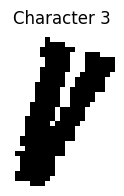

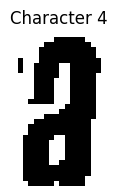

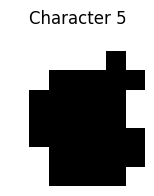

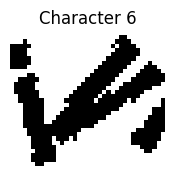

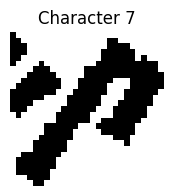

In [7]:
filedir = './try'

im = cv2.imread("try/wtvaivr-0.png")
img_name = 'wtvaivr-0.png'

im = _get_dynamic_binary_image(filedir, img_name)

im_position = CFS(im)

maxL = max(im_position[0])
minL = min(im_position[0])

# cut in the middle when the length is too long
if(maxL > minL + minL * 0.7):
    maxL_index = im_position[0].index(maxL)
    minL_index = im_position[0].index(minL)

    im_position[0][maxL_index] = maxL // 2
    im_position[0].insert(maxL_index + 1, maxL // 2)

    im_position[1][maxL_index][1] = im_position[1][maxL_index][0] + maxL // 2
    im_position[1].insert(maxL_index + 1, [im_position[1][maxL_index][1] + 1, im_position[1][maxL_index][1] + 1 + maxL // 2])

    im_position[2].insert(maxL_index + 1, im_position[2][maxL_index])

cutting_img(im,im_position,img_name,1,1)

## Drop-Fall Algorithm

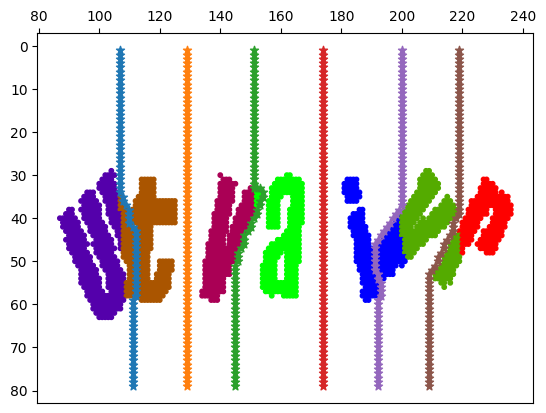

In [ ]:
def dropfall(img, start):
    a = np.array(img)
    a = (a < 200) * 1
    height, _ = a.shape
    x, y = 0, start
    way = []
    while x+1 < height:
        n1, _, n5 = a[x, y-1:y+2]
        n2, n3, n4 = a[x+1, y-1:y+2]
        if n1 == n2 == n3 == n4 == n5:
            x += 1
        elif n2 == 0 and any((n1, n3, n4, n5)):
            x += 1
            y -= 1
        elif n2 == 1 and n3 == 0:
            x += 1
        elif all((n2, n3)) and n4 == 0:
            x += 1
            y += 1
        elif all((n2, n3, n4)) and n5 == 0:
            y += 1
        elif all((n2, n3, n4, n5)) and n1 == 0:
            y -= 1
            if (x, y) in way:
                x += 1
        way.append((x, y))
    return way
        
img = Image.open('./try/wtvaivr-0.png').convert('L')
file_name = 'wtvaivr-0'
base_name = file_name.split('-')[0] 
n_clusters = len(base_name) 

a = np.array(img)
a = (a > 200) * 255
width, height = a.shape

x = []
for i in range(width):
    for j in range(height):
        if a[i, j] == 0:
            x.append([i, j])
x = np.array(x)
model = KMeans(n_clusters=n_clusters)
model.fit(x)

x_min = sorted([x[:,1][model.labels_==i].min() for i in range(n_clusters)])[1:]
x_max = sorted([x[:,1][model.labels_==i].max() for i in range(n_clusters)])[:-1]
x_positions = [(i+j)//2 for i, j in zip(x_min, x_max)]

mp.scatter(x[:,1], x[:, 0], c=model.labels_, s=10, cmap='brg')
ax = mp.gca()
ax.xaxis.set_ticks_position('top') 
ax.invert_yaxis()

for x_pos in x_positions:
    way = dropfall(img, x_pos)
    way_x = [i[0] for i in way]
    way_y = [i[1] for i in way]
    mp.scatter(way_y, way_x, marker='*')

mp.show()

## Our idea: Segment by colors

**General idea**: 

Since the characters in our CAPTCHA image are mostly in different colors, we can classify pixels based on their colors. Then, we copy pixels of the same color to a new image with a white background.

**Advantages: Compare with above two algorithms**:

1. Characters like "i" and "j" will not be mistakenly split into two images just because their pixels are not connected.

2. When characters overlap, segmentation issues won’t cause parts of one character to end up in another character’s segment.

3. Even though some parts of a character might be lost due to overlapping with others, the overall shape remains recognizable.

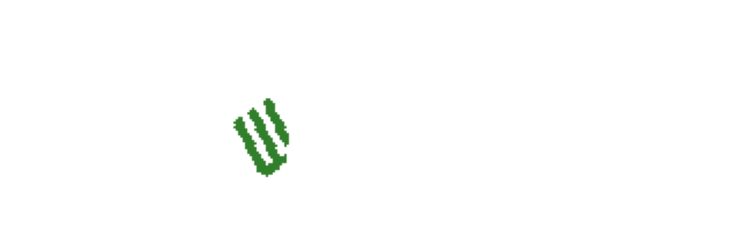

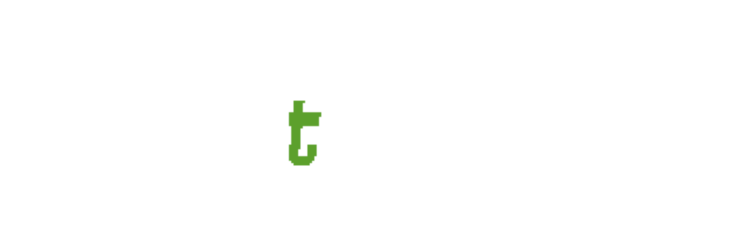

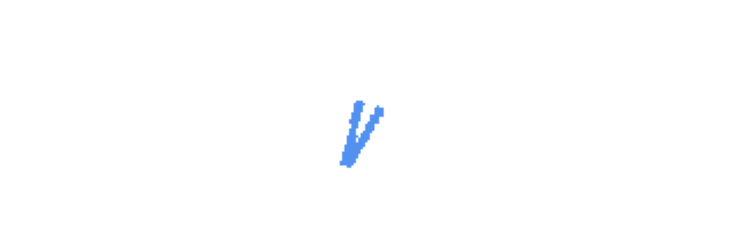

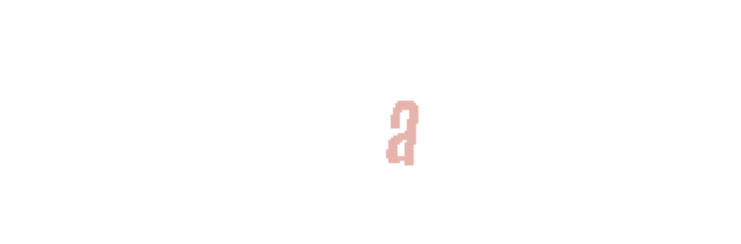

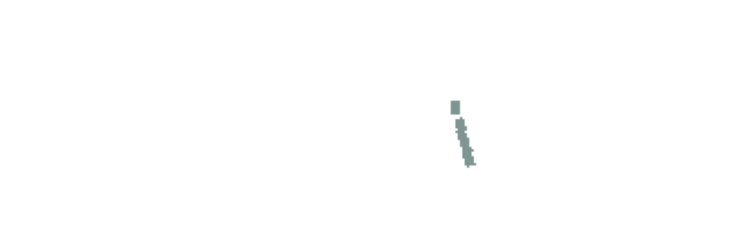

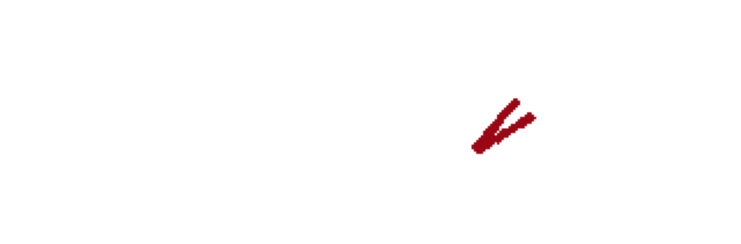

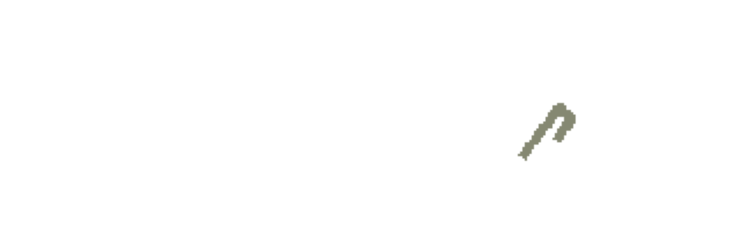

In [19]:
input_folder = './try/'
output_folder = './try/'
os.makedirs(output_folder, exist_ok=True)

background_color = (255, 255, 255)

target_files = {"wtvaivr-0.png"} 

def extract_colors(image, background_color):
    unique_colors = {}
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            pixel_color = tuple(image[y, x])
            if pixel_color != background_color:
                if pixel_color in unique_colors:
                    unique_colors[pixel_color] += 1
                else:
                    unique_colors[pixel_color] = 1
    sorted_colors = sorted(unique_colors.keys(), key=lambda x: unique_colors[x], reverse=True)
    return sorted_colors

def sort_colors_by_position(image, colors):
    color_positions = []
    for color in colors:
        y, x = np.where(np.all(image == color, axis=-1))
        avg_x = np.mean(x)
        color_positions.append((avg_x, color))
    color_positions.sort(key=lambda x: x[0])
    return [color for _, color in color_positions]

for file_name in os.listdir(input_folder):
    if file_name in target_files:  
        input_filepath = os.path.join(input_folder, file_name)
        image = cv2.imread(input_filepath)
        
        base_name = file_name.split('-')[0] 
        n_colors = len(base_name)  
        
        colors = extract_colors(image, background_color)
        if len(colors) > n_colors:
            colors = colors[:n_colors]
        
        sorted_colors = sort_colors_by_position(image, colors)
        graphic_names = list(base_name)
        name_counter = {}
        
        plt.rcParams['figure.dpi'] = 300
        
        for color, name in zip(sorted_colors, graphic_names):
            if name in name_counter:
                name_counter[name] += 1
            else:
                name_counter[name] = 1
            
            white_background = np.ones_like(image) * 255
            for y in range(image.shape[0]):
                for x in range(image.shape[1]):
                    if tuple(image[y, x]) == color:
                        white_background[y, x] = image[y, x]
            
            output_filename = os.path.join(output_folder, f'{base_name}-{name}-{name_counter[name]}.png')
            
            plt.figure(figsize=(image.shape[1] / 100, image.shape[0] / 100), dpi=300)
            plt.imshow(cv2.cvtColor(white_background, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()
            plt.savefig(output_filename, bbox_inches='tight', pad_inches=0, dpi=300)
            plt.close()


In [ ]:
# 某个颜色的频率比前一个少了一半以上；并且最少值是4和最大值是8
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

input_folder = './clean_train/'
output_folder = './try/'
os.makedirs(output_folder, exist_ok=True)

background_color = (255, 255, 255)  # 背景颜色（白色）

def extract_colors_by_frequency(image, background_color):
    """
    提取图像中所有非背景颜色，并统计每种颜色的频率。
    
    :param image: 输入图像
    :param background_color: 背景颜色
    :return: 按频率排序的颜色列表和对应的频率列表
    """
    unique_colors = {}
    
    # 统计每种颜色的频率
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            pixel_color = tuple(image[y, x])
            if pixel_color != background_color:
                if pixel_color in unique_colors:
                    unique_colors[pixel_color] += 1
                else:
                    unique_colors[pixel_color] = 1
    
    # 按频率排序
    sorted_colors = sorted(unique_colors.keys(), key=lambda x: unique_colors[x], reverse=True)
    sorted_frequencies = [unique_colors[color] for color in sorted_colors]
    print(sorted_colors)
    print(sorted_frequencies)
    
    return sorted_colors, sorted_frequencies

def find_frequency_cutoff(colors, frequencies, min_colors=4, max_colors=8):
    """
    找到频率分布的断层点：
    - 如果某个颜色的频率比前一个少了一半以上（<50%），则认为是断层点。
    - 最少提取 min_colors 种颜色，最多提取 max_colors 种颜色。
    
    :param colors: 按频率排序的颜色列表
    :param frequencies: 对应的频率列表
    :param min_colors: 最少提取的颜色数量
    :param max_colors: 最多提取的颜色数量
    :return: 断层点之前的颜色列表
    """
    if not frequencies or len(frequencies) < min_colors:
        return colors[:min_colors] if len(colors) >= min_colors else colors
    
    # 遍历频率，找到第一个频率下降超过50%的点
    cutoff_index = min_colors  # 至少取 min_colors 种颜色
    for i in range(min_colors, min(len(frequencies), max_colors)):
        if frequencies[i] < 0.5 * frequencies[i-1]:
            cutoff_index = i
            break
    else:
        # 如果没有找到断层点，就取前 max_colors 种颜色
        cutoff_index = min(len(frequencies), max_colors)
    
    return colors[:cutoff_index]

def sort_colors_by_position(image, colors):
    """
    根据颜色在图像中的水平位置排序。
    """
    color_positions = []
    for color in colors:
        y, x = np.where(np.all(image == color, axis=-1))
        avg_x = np.mean(x)
        color_positions.append((avg_x, color))
    color_positions.sort(key=lambda x: x[0])
    return [color for _, color in color_positions]

for file_name in os.listdir(input_folder):
    input_filepath = os.path.join(input_folder, file_name)
    image = cv2.imread(input_filepath)
    
    # 提取颜色和频率
    colors, frequencies = extract_colors_by_frequency(image, background_color)
    
    # 找到频率断层点（频率下降超过50%时停止，且最少4种，最多8种）
    selected_colors = find_frequency_cutoff(colors, frequencies, min_colors=4, max_colors=8)
    
    # 根据颜色位置排序
    sorted_colors = sort_colors_by_position(image, selected_colors)
    
    # 生成输出文件名
    base_name = os.path.splitext(file_name)[0]  # 去掉文件扩展名
    graphic_names = list(base_name[:len(selected_colors)])  # 根据颜色数量截取名字
    
    name_counter = {}
    
    plt.rcParams['figure.dpi'] = 300
    
    # 为每种颜色生成图像
    for color, name in zip(sorted_colors, graphic_names):
        if name in name_counter:
            name_counter[name] += 1
        else:
            name_counter[name] = 1
        
        # 创建白色背景
        white_background = np.ones_like(image) * 255
        for y in range(image.shape[0]):
            for x in range(image.shape[1]):
                if tuple(image[y, x]) == color:
                    white_background[y, x] = image[y, x]
        
        # 保存图像
        output_filename = os.path.join(output_folder, f'{base_name}-{name}-{name_counter[name]}.png')

        '''
        plt.figure(figsize=(image.shape[1] / 100, image.shape[0] / 100), dpi=300)
        plt.imshow(cv2.cvtColor(white_background, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
        plt.savefig(output_filename, bbox_inches='tight', pad_inches=0, dpi=300)
        plt.close()
        '''

        print(f"Saved {output_filename}")